In [113]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import scipy
import scipy.stats
from itertools import groupby

from sklearn.model_selection import train_test_split

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import hvplot.xarray

from mlprecip_utils import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
cmap='DryWet'
clevs=np.arange(-0.8,0.9,0.1)
labels=['Positive','Neutral','Negative']
v='precip'
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]
winter=[12,1,2]
summer=[6,7,8]

In [4]:
fnames='/scratch/zmanthos/GPCP/gpcp_v01r03_daily.*.nc'
ds=getPrecipData(fnames,'1996-12-15','2020-01-15').rename({'latitude':'lat','longitude':'lon'}).reset_coords(['longitude_bnds','latitude_bnds'],drop=True)

In [5]:
ds_seus=ds.sel(lat=slice(lat_reg[0],lat_reg[1]),lon=slice(lon_reg[0],lon_reg[1]))
ds_seus

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 13, lon: 15, time: 8432)
Coordinates:
  * lon        (lon) float32 269.0 270.0 271.0 272.0 ... 280.0 281.0 282.0 283.0
  * lat        (lat) float32 24.0 25.0 26.0 27.0 28.0 ... 33.0 34.0 35.0 36.0
  * time       (time) datetime64[ns] 1996-12-15 1996-12-16 ... 2020-01-15
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(17, 2), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(17, 13, 15), meta=np.ndarray>
Attributes: (12/47)
    CDI:                        Climate Data Interface version 1.8.2 (http://...
    history:                    Thu Sep 17 20:06:27 2020: cdo cat /scratch/zm...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199610/s...
    institution:                ACADEMIC > UMD/ESSIC > Earth System Science I...
    Conventions:                CF-1.6, ACDD 1.3
    title:                      Global Precipitation Climatatology Project (G...
    ...                         ...
    product_version:            v01r03
    platform:                   GOES (Geostationary Operational Environmental...
    sensor:                     Imager, TOVS > TIROS Operational Vertical Sou...
    spatial_resolution:         1 degree
    comment:                    Processing computer: eagle2.umd.edu
    CDO:                        Climate Data Operators version 1.8.2 (http://...

In [6]:
ds_anoms=ds_seus.groupby('time.month')-ds_seus.groupby('time.month').mean()
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 15, time: 8432)
Coordinates:
  * lon      (lon) float32 269.0 270.0 271.0 272.0 ... 280.0 281.0 282.0 283.0
  * lat      (lat) float32 24.0 25.0 26.0 27.0 28.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1996-12-15 1996-12-16 ... 2020-01-15
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 ... 1 1 1 1 1 1 1 1 1 1
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(17, 13, 15), meta=np.ndarray>

In [7]:
ds_anoms_index=ds_anoms.mean(dim=['lat','lon'])
ds_anoms_index

<xarray.Dataset>
Dimensions:  (time: 8432)
Coordinates:
  * time     (time) datetime64[ns] 1996-12-15 1996-12-16 ... 2020-01-15
    month    (time) int64 12 12 12 12 12 12 12 12 12 12 ... 1 1 1 1 1 1 1 1 1 1
Data variables:
    precip   (time) float32 dask.array<chunksize=(17,), meta=np.ndarray>

expon (1.0, 1.0573248407643314)
rayleigh (0.14442755345061878, 1.6110434105847773)
norm (2.0573248407643314, 1.2376371478608348)
pareto (0.36542943293765107, 0.9999999323498154, 6.250437407565817e-08)
gamma (0.6210668739031991, 0.9999999999999998, 0.9779643234199735)
expon (1.0, 3.6528662420382165)
rayleigh (-1.158830289330188, 4.9033280041485785)
norm (4.6528662420382165, 3.7827813127136776)
pareto (17.94367429807543, -60.93344816007637, 61.93344815985572)
gamma (0.8789159205425112, 0.9999999999999998, 3.072002951261204)
expon (1.0, 2.043189368770764)
rayleigh (-0.6841006099792155, 3.1848213530215874)
norm (3.043189368770764, 2.528533866815805)
pareto (1.4623906170710583, -0.42774211498638554, 1.427742114839193)
gamma (0.8391923280151677, 0.9999999999999998, 2.371387512547611)
expon (1.0, 2.9867109634551494)
rayleigh (-1.0354935190516958, 4.282377305147264)
norm (3.9867109634551494, 3.3845195971022)
pareto (5.329738221811866, -12.049738446902225, 13.049738446672094)
gamma (0.331414341

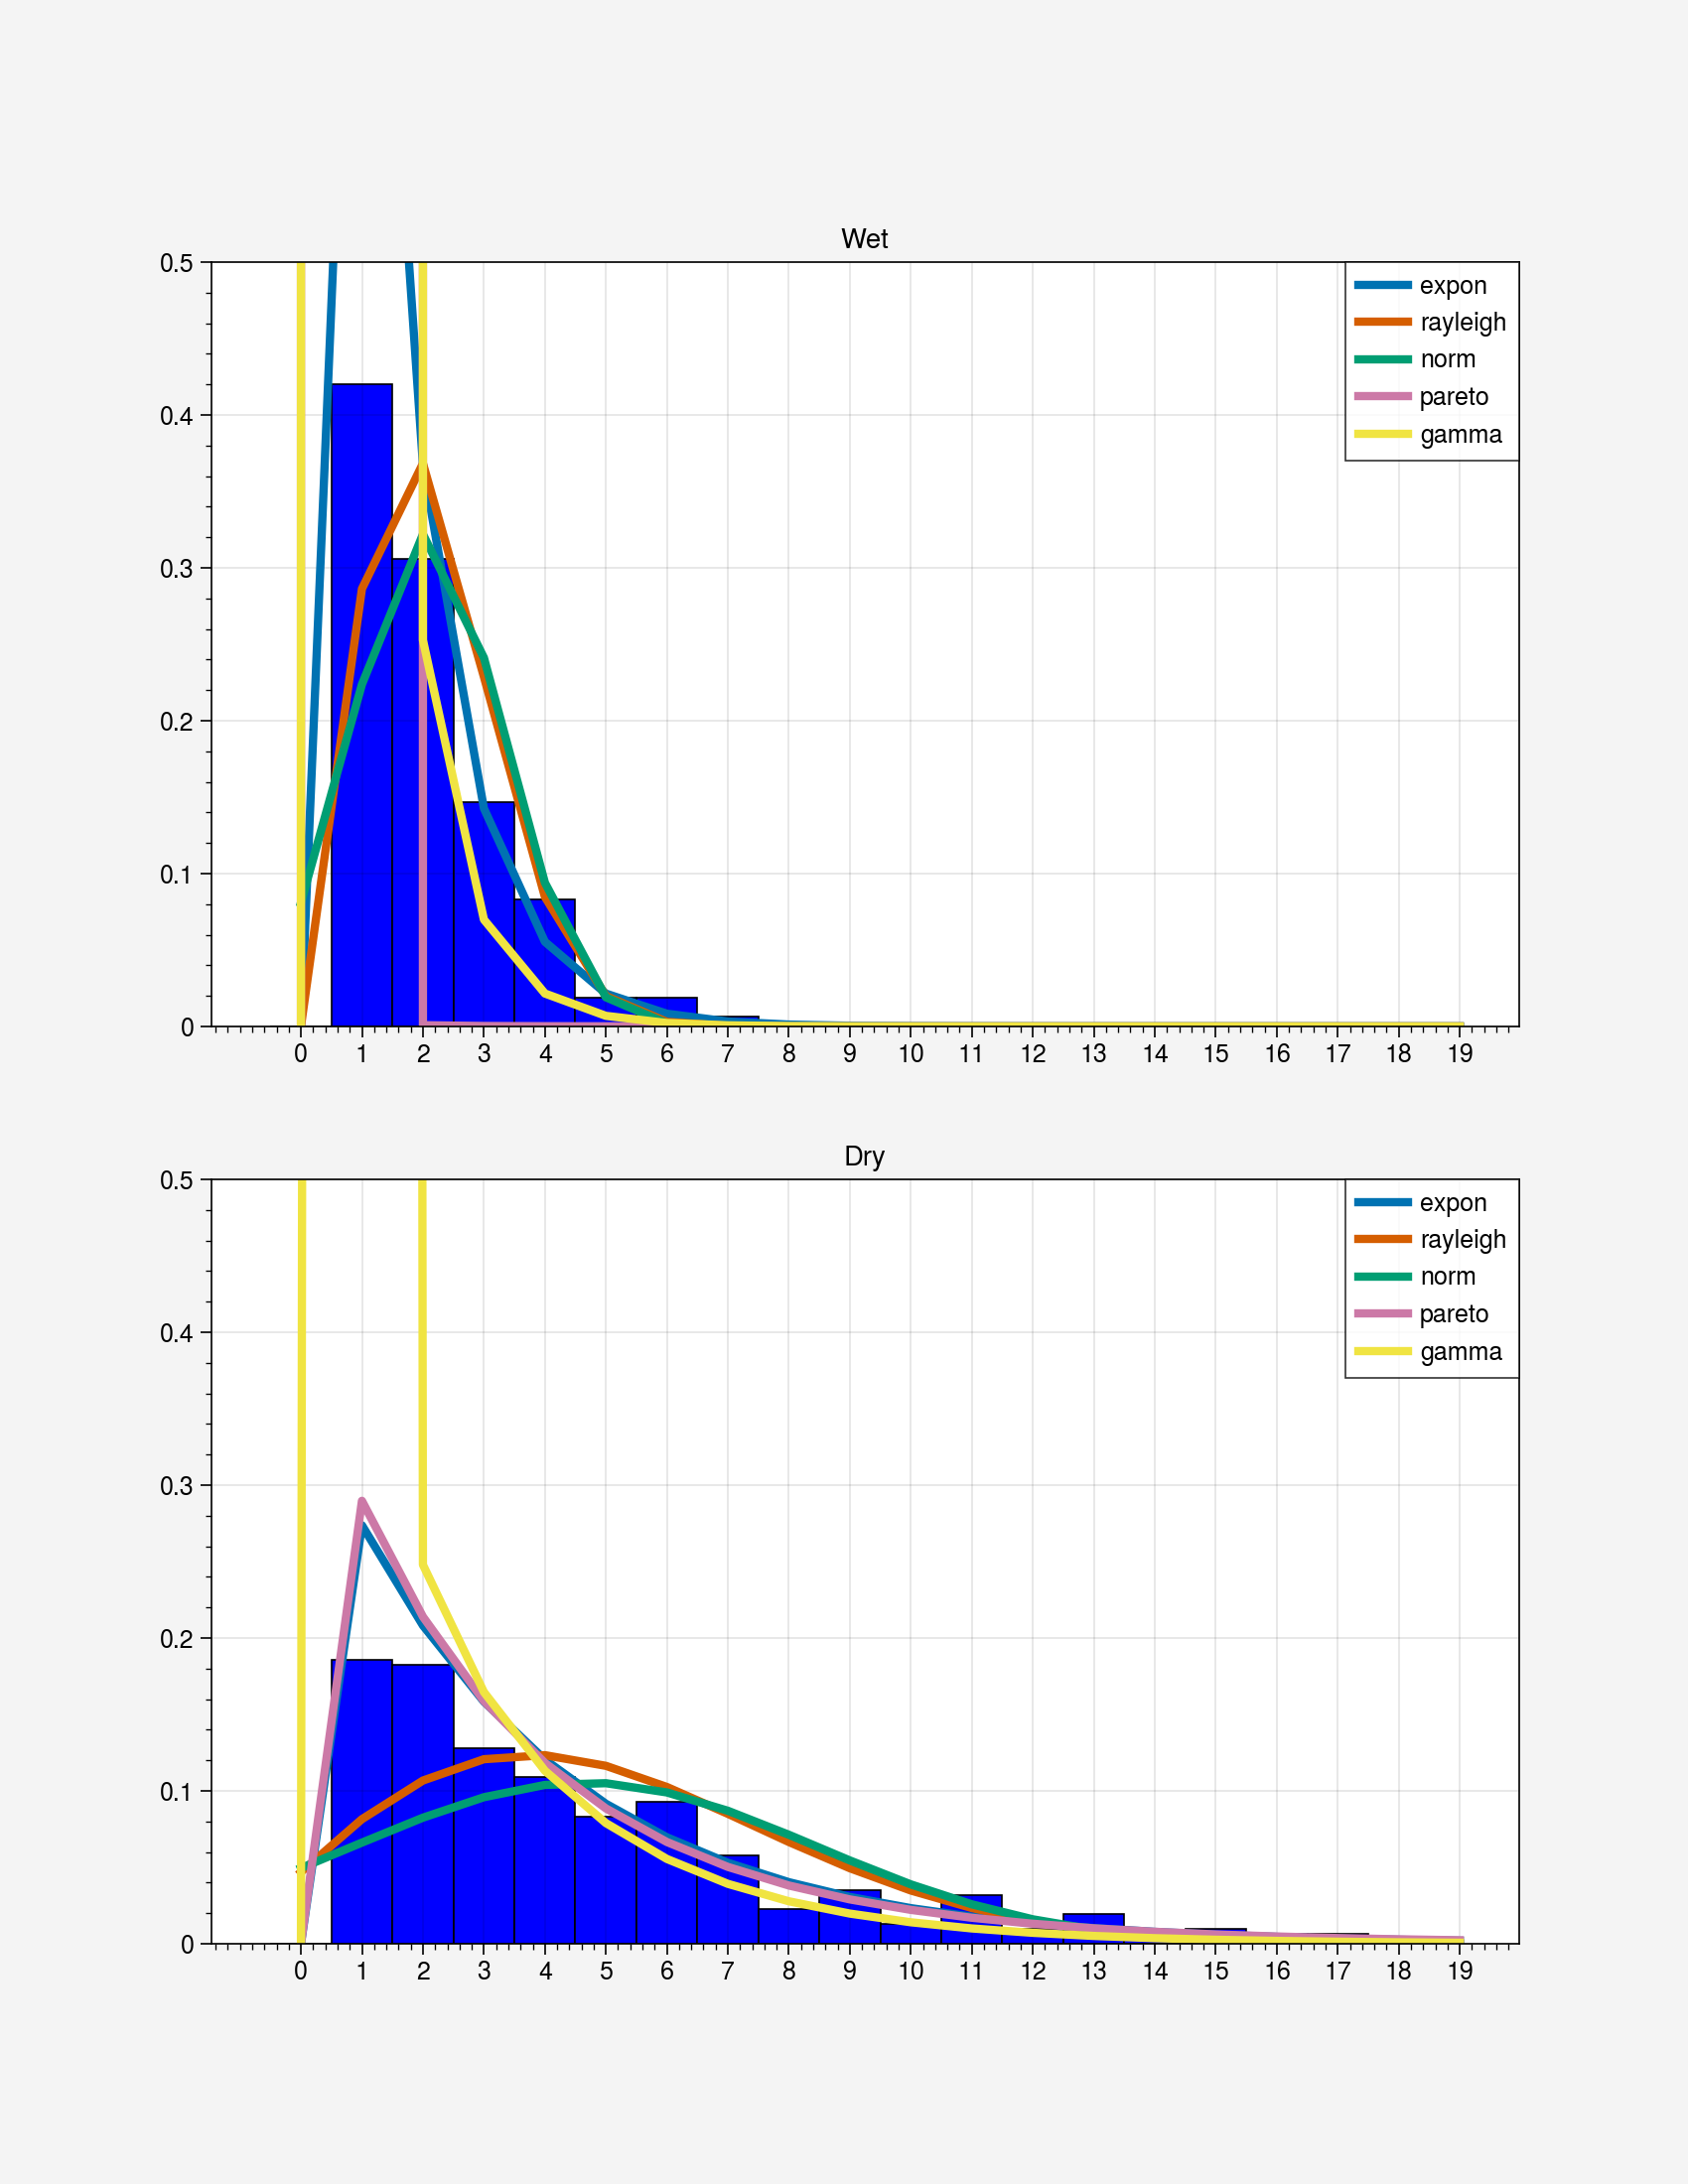

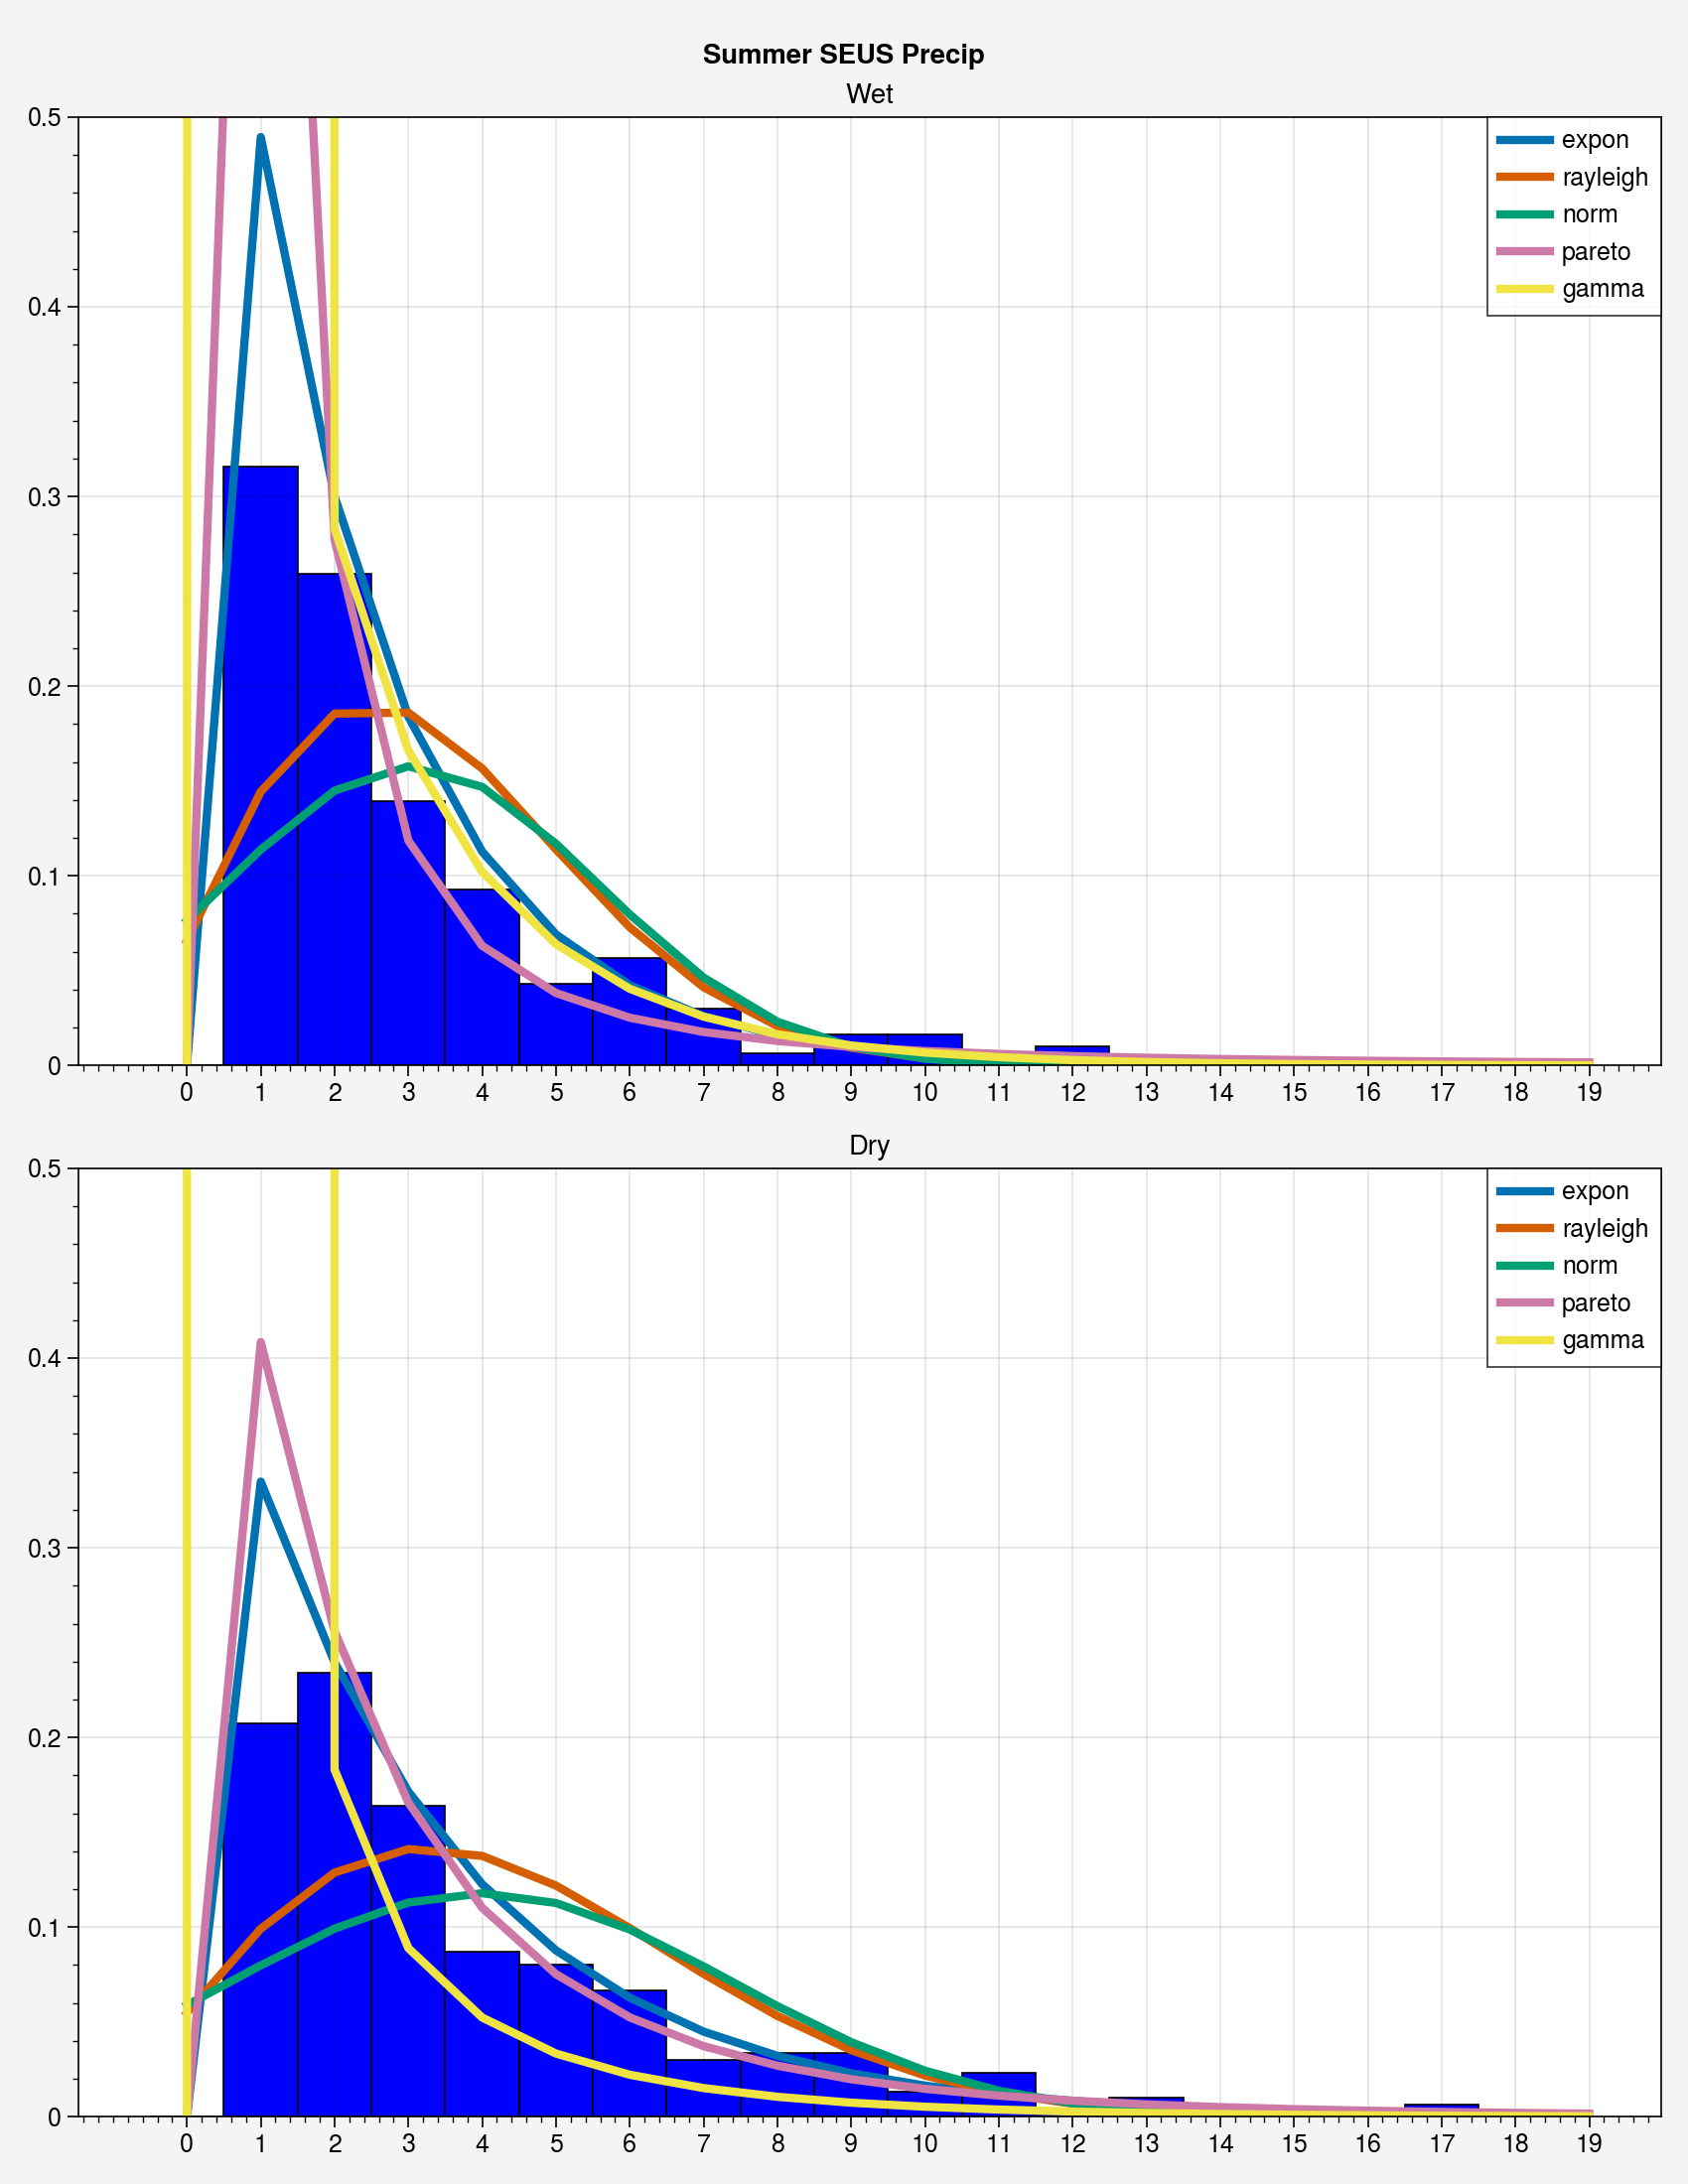

In [205]:
dist_names = ['expon','rayleigh', 'norm', 'pareto','gamma']
x=np.arange(0,20)


winter=[12,1,2]
summer=[6,7,8]

for mseas,lseas in zip([winter,summer],['winter','summer']):

    fig=plt.figure(figsize=(8.5,11.0)) 
    axs=fig.subplots(2,1)
    
    # Get data in seas
    ds_tmp=ds_anoms_index.sel(time=ds_anoms_index['time.month'].isin(mseas))
    
    # Identify above and below normal and count up events
    da=xr.where(ds_tmp['precip']>0.0,1,0)
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(da.values)]
    above_list=[]
    below_list=[]
    for xtmp in grouped_L:
        if (xtmp[0]==1):
            above_list.append(xtmp[1])
        else:
            below_list.append(xtmp[1])

    # Plot histograms and distribution fits
    for ax,p,t in zip(axs,[above_list,below_list],['Wet','Dry']):
        for dist_name in dist_names:
            dist = getattr(scipy.stats, dist_name)
            params = dist.fit(p)
            print(dist_name,params)
            y = dist.pdf(x,*params)
            ax.plot(x,y,lw=3)
               
        ax.hist(p,bins=x-0.5,density=True,color='blue',edgecolor='k')
        ax.set_title(t)
        ax.set_ylim([0,0.5])
        ax.set_xticks(x)
        ax.legend(dist_names)

plt.suptitle(lseas.capitalize()+' SEUS Precip')
plt.tight_layout()